# Estimation of simulated VAR by ML using only  numpy

## Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

np.random.seed(1)

## Simulation of stationary time-series

In [2]:
# Time-series dimension of simulation

nsample = 1000
nvar = 3

In [3]:
# Create null data frames for storing data

df = np.empty((nsample, nvar))
rho = np.empty((nvar))

In [4]:
# Simulation of processes

# Start values

for i in np.arange(0, df.shape[1]):
    df[0,i] = np.random.random()
    
# Rho parameters, smaller than one in absolute value
for i in np.arange(0, df.shape[1]):
    rho[i] = np.random.uniform(-0.99, 0.99)

# Create the AR(1) processes
for i in np.arange(1,df.shape[0]):
    for j in np.arange(0, df.shape[1]):
        df[i,j] = rho[j]*df[i-1, j] + np.random.normal()

# print(df)

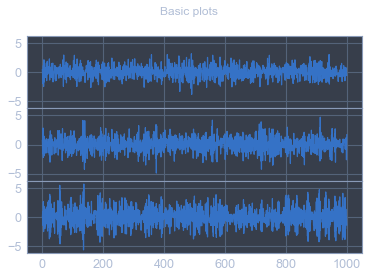

In [5]:
# Plots

f, axarr = plt.subplots(3, sharex=True, sharey=True)
f.suptitle('Basic plots')

for i in np.arange(0, df.shape[1]):
    axarr[i].plot(df[:,i])

# Bring subplots close to each other.
f.subplots_adjust(hspace=0)

# Hide x labels and tick labels for all but bottom plot.
for ax in axarr:
    ax.label_outer()

## VAR

In [6]:
class VAR:
    """ 
    **** VECTOR AUTOREGRESSION (VAR) MODELS ****
    ----------
    Parameters
    data : np.array
        Field to specify the time series data that will be used.
    lags : int
        Field to specify how many lag terms the model will have. 
    integ : int (default : 0)
        Specifies how many time to difference the dependent variables.
    target : str (pd.DataFrame) or int (np.array) (default : None)
        By default, all columns will be selected as the dependent variables.
    """

    def __init__(self,data,lags,target=None,integ=0):
        
        # Latent Variables
        self.lags = lags
        self.integ = integ
        self.target = target
        self.model_name = "VAR(" + str(self.lags) + ")"
        
        # Format the dependant variables
        self.data = data
        self.T = data.shape[0]
        self.ylen = data.shape[1]
        
        # Format the independent variables
        
        ## TO DO
        
        # Difference data
        X = np.transpose(self.data)
        for order in np.arange(self.integ):
            X = np.asarray([np.diff(i) for i in X])
            self.data_name = np.asarray(["Differenced " + str(i) for i in self.data_name])
        self.data = X.T
        
        """
        Y : np.array
            Contains the length-adjusted time series (accounting for lags)
        """     

        self.Y = (self.data[self.lags:,]).T
        
    def _design(self):
        """ Creates a design matrix
        Z : np.array
        """ 
        
        Z = np.ones(((self.ylen*self.lags+1), (self.T-self.lags)))

        row_count=1
        for lag in np.arange(1, self.lags+1):
            for reg in np.arange(self.ylen):
                Z[row_count, :] = self.data[:,reg][(self.lags-lag):-lag]
                row_count += 1
                
        return(Z)

    def OLS(self):
        """ Creates OLS coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix B
        """         
        
        Z = self._design()
        return np.dot(np.dot(self.Y,np.transpose(Z)),np.linalg.inv(np.dot(Z,np.transpose(Z))))
    
    def _neg_loglike(self, par):
        """ Calculate the MLE value, given the mean vector and variance matrix        
        """
        
        Z = self._design()[1:]
        
        coef = np.reshape(par[0:self.ylen**2], (self.ylen, self.ylen))
        coef_mean = par[self.ylen**2:self.ylen**2+self.ylen]
        coef_var = np.diag(par[self.ylen**2+self.ylen:])    
        
#         General form of variance-covariance matrix
#         coef_var[0,0] = par[self.ylen**2+self.ylen]
#         coef_var[0,1] = par[self.ylen**2+self.ylen+1]
#         coef_var[0,2] = par[self.ylen**2+self.ylen+2]
#         coef_var[1,0] =coef_var[0,1]
#         coef_var[1,1] = par[self.ylen**2+self.ylen+3]
#         coef_var[1,2] = par[self.ylen**2+self.ylen+4]
#         coef_var[2,0] = coef_var[0,2]
#         coef_var[2,1] = coef_var[2,1]
#         coef_var[2,2] = par[self.ylen**2+self.ylen+5]

        Y_0 = (self.Y.T - coef_mean).T
        Z_0 = (Z.T - coef_mean).T 
        
        logLik = -self.Y.shape[1]*self.ylen*np.log(2*np.pi)*.5 
        - .5*self.Y.shape[1]*np.log(np.abs(np.linalg.det(coef_var)))
        - .5*np.trace(np.dot(np.dot((Y_0 - np.dot(coef,Z_0)).T,np.linalg.inv(coef_var)),Y_0 - np.dot(coef,Z_0)))
        
        return -logLik

    def _con_1(self, x):
            x[-3]
    def _con_2(self, x):
            x[-2]
    def _con_3(self, x):
            x[-1]
    
#         General form of variance-covariance matrix
#     def _con_1(self, x):
#         x[self.ylen**2+self.ylen]
#     def _con_2(self, x):
#         x[self.ylen**2+self.ylen+3]
#     def _con_3(self, x):
#         x[self.ylen**2+self.ylen+5]
    
    def MLE(self):
        """ Creates MLE coefficient matrix
        ----------
        Parameters:
        NULL
        ----------
        Returns
        The coefficient matrix MLE
        ----------
        It is based on the assumption of normality of errors
        """     
        
        cons = [{'type':'ineq', 'fun': self._con_1},
                {'type':'ineq', 'fun': self._con_2},
               {'type':'ineq', 'fun': self._con_3}]

        # Make a list of initial parameter guesses 
        
#         General form of variance-covariance matrix
#         initParams = np.random.uniform(-1,1, (self.ylen)**2 + self.ylen + int((self.ylen*(self.ylen+1))/2) )

        initParams = np.concatenate((np.random.uniform(-1,1, (self.ylen)**2 + self.ylen), np.random.uniform(0,1, self.ylen)))

        # Run the minimizer
        results = minimize(self._neg_loglike, initParams, constraints = cons, method='COBYLA')

        # Print the results
        return(results.x)

In [7]:
# Estimate VAR(1) by OLS

# In general

OLS_results = VAR(data = df, lags = 1, target = None, integ = 0).OLS()
OLS_results

# For more clarity

par_names_OLS = ['X Constant','X AR(1)','Y to X AR(1)','Z to X AR(1)','Y Constant','Y AR(1)','X to Y AR(1)','Z to Y AR(1)','Z Constant','Z AR(1)','X to Z AR(1)','Y to Z AR(1)'] 
results_OLS =  dict(zip(par_names_OLS, OLS_results.flatten()))
results_OLS

{'X Constant': 0.015315963731588864,
 'X AR(1)': -0.4160227350090755,
 'Y to X AR(1)': -0.004951484106548238,
 'Z to X AR(1)': -0.002910356206938059,
 'Y Constant': 0.017964110451716142,
 'Y AR(1)': 0.02056997022652607,
 'X to Y AR(1)': -0.6819845347371097,
 'Z to Y AR(1)': -0.011673345503860766,
 'Z Constant': 0.011471441055540588,
 'Z AR(1)': -0.02607243277119667,
 'X to Z AR(1)': -0.005456758111535556,
 'Y to Z AR(1)': -0.8180100817371425}

In [8]:
# Estimate VAR(1) by MLE

MLE_results = VAR(data = df, lags = 1, target = None, integ = 0).MLE()
MLE_results

# For more clarity

# par_names_MLE = par_names_MLE =  ['X AR(1)','Y to X AR(1)','Z to X AR(1)','Y AR(1)','X to Y AR(1)','Z to Y AR(1)','Z AR(1)','X to Z AR(1)','Y to Z AR(1)', 
#                   'X Constant','Y Constant', 'Z Constant', 'Var(X)', 'Cov(X,Y)', 'Cov(X,Z)', 'Var(Y)', 'Cov(Y,Z)', 'Var(Z)']
# results_MLE = dict(zip(par_names_MLE, MLE_results.flatten()))
# results_MLE

par_names_MLE = par_names_MLE =  ['X AR(1)','Y to X AR(1)','Z to X AR(1)','Y AR(1)','X to Y AR(1)','Z to Y AR(1)','Z AR(1)','X to Z AR(1)','Y to Z AR(1)', 
                  'X Constant','Y Constant', 'Z Constant', 'Var(X)', 'Var(Y)', 'Var(Z)']
results_MLE = dict(zip(par_names_MLE, MLE_results.flatten()))
results_MLE

{'X AR(1)': 0.7312489751148545,
 'Y to X AR(1)': 0.7774000990605243,
 'Z to X AR(1)': 0.9261041737248161,
 'Y AR(1)': -0.3436015047707315,
 'X to Y AR(1)': 0.3866403115819286,
 'Z to Y AR(1)': 0.26613253579142815,
 'Z AR(1)': -0.5151125088201036,
 'X to Z AR(1)': 0.7399752526853569,
 'Y to Z AR(1)': -0.5717961684607402,
 'X Constant': 0.4954280053015603,
 'Y Constant': -0.7106721289715421,
 'Z Constant': -0.7863606875207767,
 'Var(X)': 0.7203222101235442,
 'Var(Y)': 0.5263181160447106,
 'Var(Z)': 0.4429158313362551}